<div align="center"><h1> <font color='cyan'>Assignment 2 - Building Neural Networks and CNNs</font>

<h3>Checkpoint: October 24, Thu, 11:59pm</h3>
<h2><font color='red'>Due Date: November 7, Thu, 11:59pm</h2></font> 
</div>


<h2><font color='green'>Part IV: VGG-13 Implementation [20 points]</font></h2>

VGG is one of the commonly used CNN architectures. It has different versions. In this part we implement the VGG-13 (Version B) and apply it to solve our task. The expected accuracy on the testing dataset for this task is > 85%.

<h1>Step 1: ImplementtheVGG-13(Version B) architecture following the proposed architecture and adjusting it to fit our dataset.</h1>

<h1>Step 2: Adjustments based on your dataset:</h1>
<ul>
  <li>The input size for the original VGG is 224x224. Here are a few options:
    <ul>
      <li>You can remove a few max pooling layers.</li>
      <li>Add padding to your convolutional layers to maintain more spatial dimensions.</li>
      <li>Resize your input size.</li>
    </ul>
  </li>
  <li>The last layer of the original VGG contains 1000 classes. You can modify it to fit the number of your classes (e.g., 36).</li>
</ul>
<h1>Step 3: Use the dropout and learning rate scheduler, as in the VGG paper<h1>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
from torchinfo import summary

class VGG13(nn.Module):
    def __init__(self, num_classes=36):
        super(VGG13, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

<h1>4. Train the model on a dataset used in PartIII (EMNIST).</h1>
<h2>4.1 Loading the dataset.</h2>

In [2]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32 to maintain spatial dimensions
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # EMNIST normalization values
])

# Load EMNIST dataset
dataset = datasets.ImageFolder('cnn_dataset', transform=transform)
train_dataset = datasets.ImageFolder('cnn_dataset', transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<h2>4.2 Setting the hyperparameters.</h2>

In [4]:
model = VGG13().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

<h2>4.3 Training the model.</h2>

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time

# Assuming you have your model, criterion, optimizer, scheduler, and dataloaders defined
start_time = time.time()
num_epochs = 5
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if i % 100 == 0:
            print(f" Loss: {loss.item():.4f}, iteration : {i}/{len(train_dataloader)}")
    
    train_loss = running_loss / len(train_dataloader)
    train_accuracy = 100. * correct / total
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")
    
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss = val_running_loss / len(val_dataloader)
    val_accuracy = 100. * val_correct / val_total
    
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    # Step the learning rate scheduler
    scheduler.step()

end_time = time.time()
print(f"Training complete in {(end_time - start_time):.2f} seconds")


 Loss: 3.5846, iteration : 0/1103
 Loss: 3.5790, iteration : 100/1103
 Loss: 3.5685, iteration : 200/1103
 Loss: 2.7170, iteration : 300/1103
 Loss: 1.3158, iteration : 400/1103
 Loss: 0.9262, iteration : 500/1103
 Loss: 0.6482, iteration : 600/1103
 Loss: 0.6472, iteration : 700/1103
 Loss: 0.6445, iteration : 800/1103
 Loss: 0.4945, iteration : 900/1103
 Loss: 0.2487, iteration : 1000/1103
 Loss: 0.6189, iteration : 1100/1103
Epoch [1/5], Training Loss: 1.5066, Training Accuracy: 55.60%
Epoch [1/5], Validation Loss: 0.3825, Validation Accuracy: 85.99%
 Loss: 0.4205, iteration : 0/1103
 Loss: 0.2535, iteration : 100/1103
 Loss: 0.3070, iteration : 200/1103
 Loss: 0.4500, iteration : 300/1103
 Loss: 0.2300, iteration : 400/1103
 Loss: 0.3000, iteration : 500/1103
 Loss: 0.2534, iteration : 600/1103
 Loss: 0.2860, iteration : 700/1103
 Loss: 0.2848, iteration : 800/1103
 Loss: 0.3263, iteration : 900/1103
 Loss: 0.3900, iteration : 1000/1103
 Loss: 0.3501, iteration : 1100/1103
Epoch [2

<h1>5. Evaluate the performance of the model on the testing data and visualize the results.</h1>

<h2>5.1 Evaluating the performance metrics.</h2>

In [6]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()

all_predictions = []
all_labels = []
test_loss = 0.0
criterion = nn.CrossEntropyLoss()  # Make sure this matches your training loss function

# Disable gradient calculation for evaluation
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate average loss
test_loss /= len(test_dataloader)

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

accuracy = accuracy*100

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Test Loss: 0.2778
Accuracy: 90.2910%
Precision: 0.9083
Recall: 0.9029
F1 Score: 0.9026


<h2>5.2 Visualizing the results.</h2>

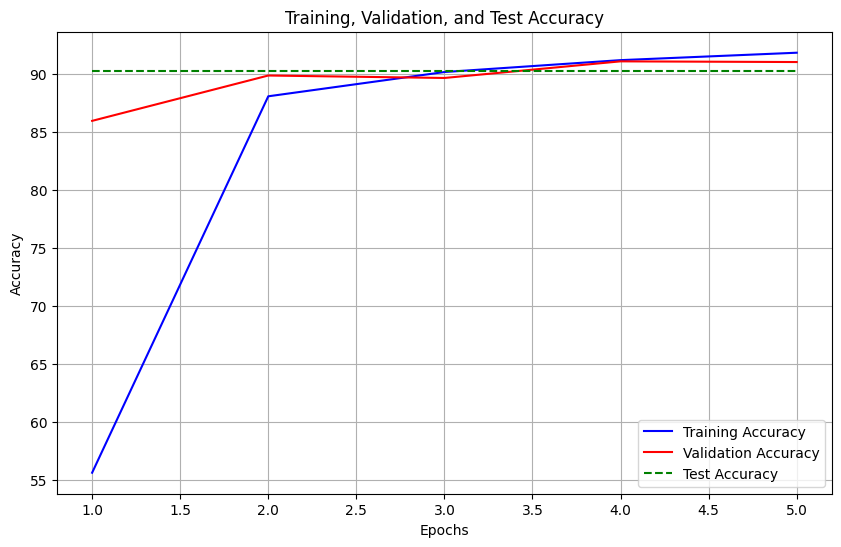

In [7]:
num_epochs = len(train_accuracies)
epochs = range(1, num_epochs + 1)

# a. Accuracy Graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.plot(epochs, [accuracy] * num_epochs, 'g--', label='Test Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

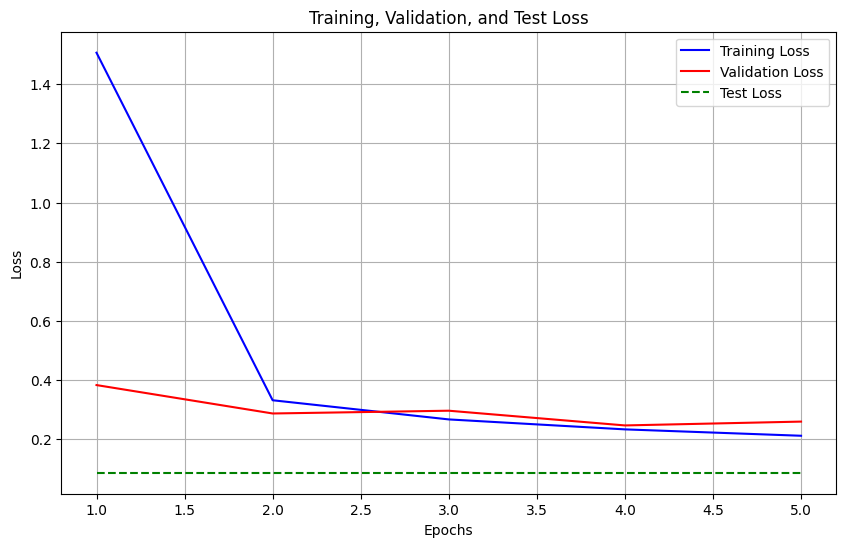

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.plot(epochs, [loss] * num_epochs, 'g--', label='Test Loss')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

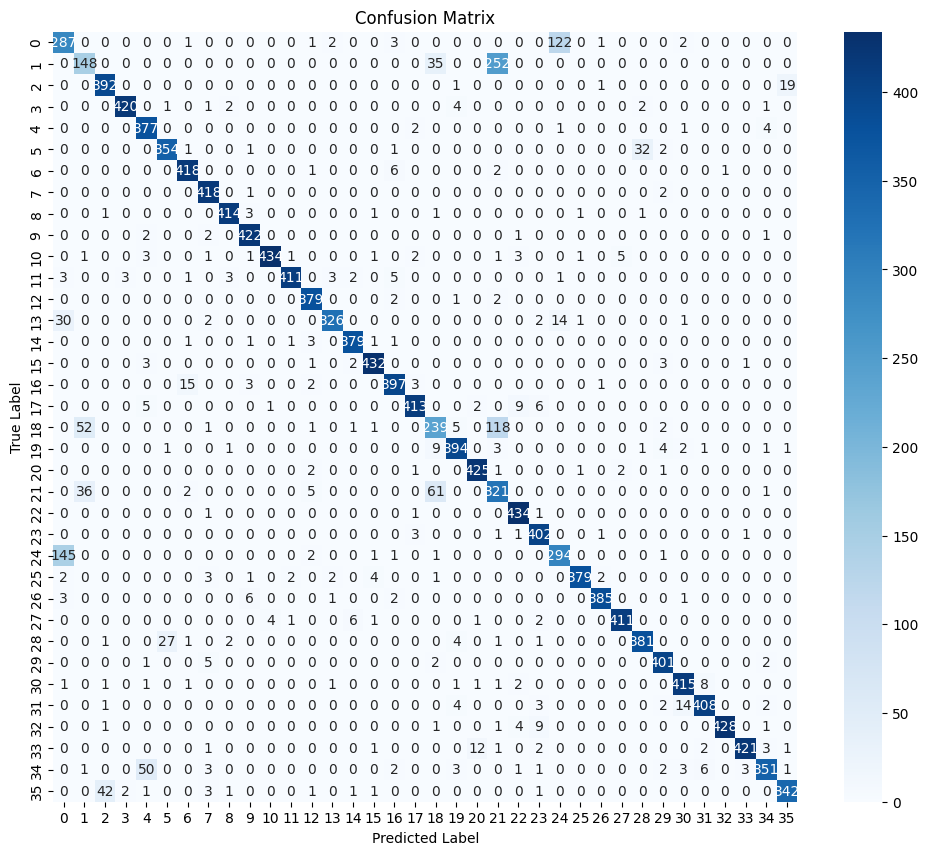

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

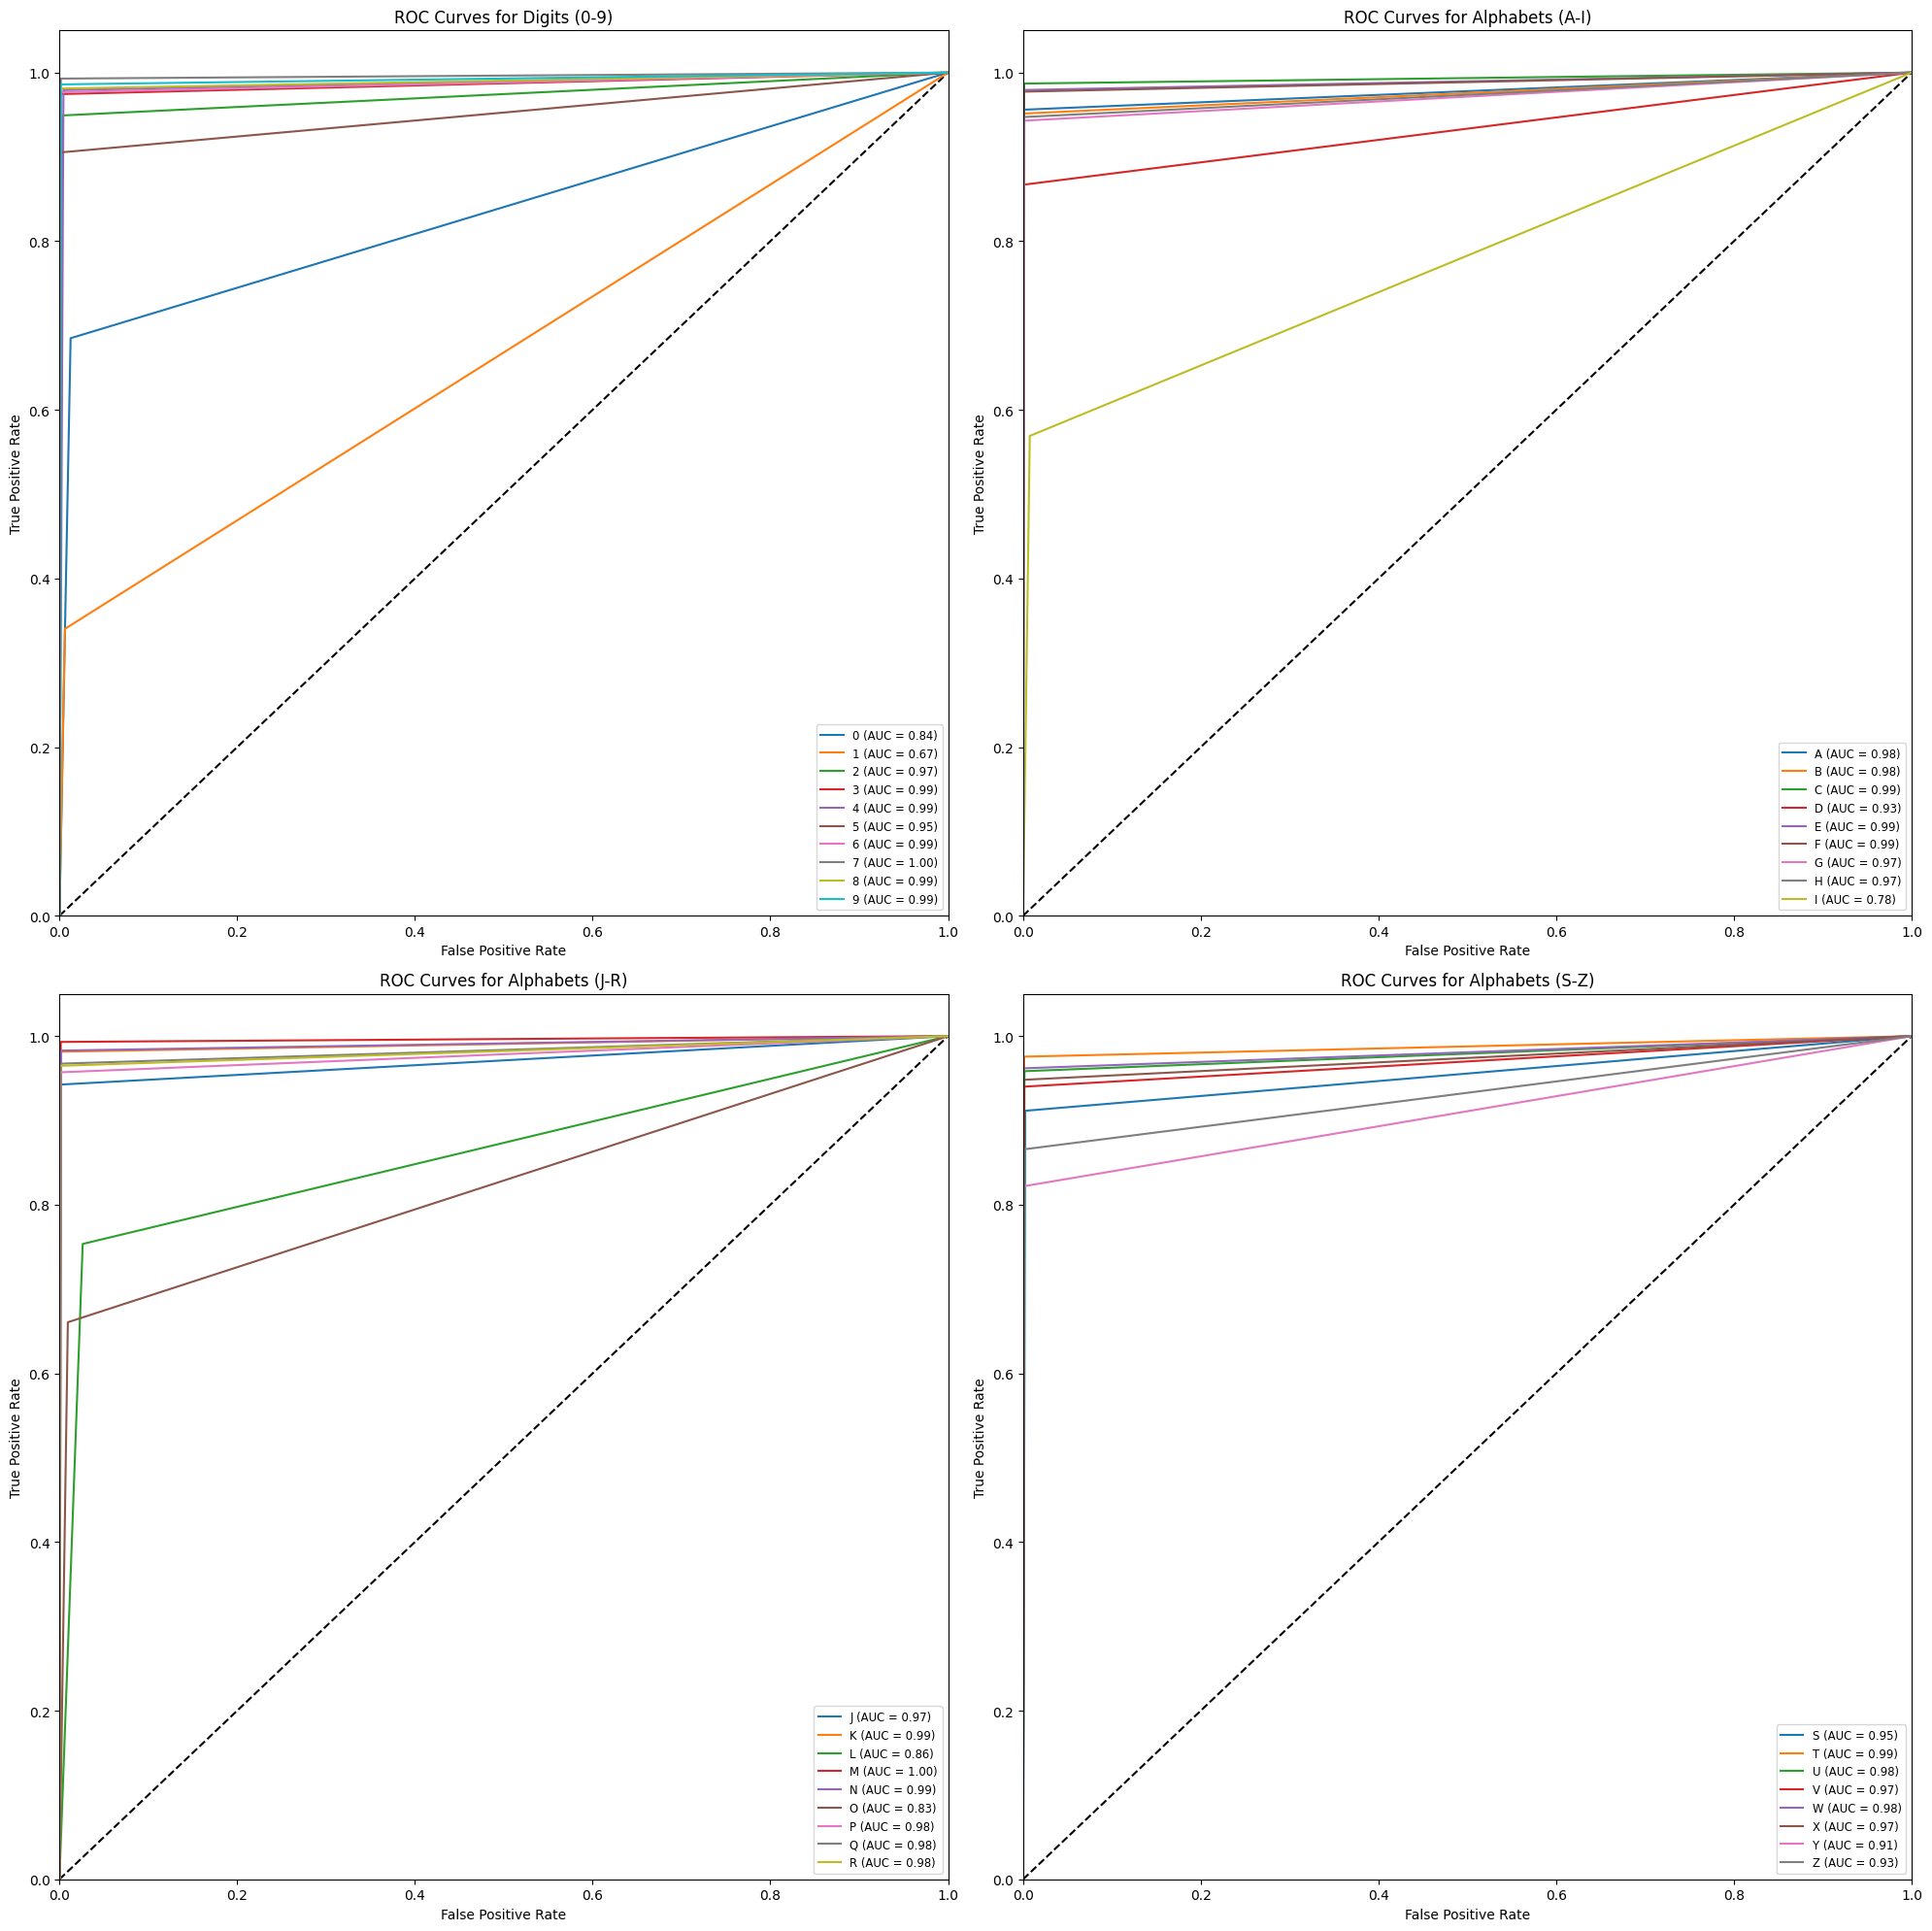

Average AUC: 0.9505


In [10]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

all_preds = np.array(all_predictions)
all_labels = np.array(all_labels)

classes = np.unique(np.concatenate((all_labels, all_preds)))
n_classes = len(classes)

all_labels_bin = label_binarize(all_labels, classes=classes)
all_preds_bin = label_binarize(all_preds, classes=classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_preds_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fig, axs = plt.subplots(2, 2, figsize=(20, 20))
axs = axs.ravel()

axs[0].plot([0, 1], [0, 1], 'k--')
for i in range(10):
    axs[0].plot(fpr[i], tpr[i], label=f'{i} (AUC = {roc_auc[i]:.2f})')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC Curves for Digits (0-9)')
axs[0].legend(loc="lower right", fontsize='small')

for j in range(1, 4):
    axs[j].plot([0, 1], [0, 1], 'k--')
    for k in range(9):
        idx = 10 + (j-1)*9 + k
        if idx < n_classes:
            axs[j].plot(fpr[idx], tpr[idx], label=f'{chr(65+idx-10)} (AUC = {roc_auc[idx]:.2f})')
    axs[j].set_xlim([0.0, 1.0])
    axs[j].set_ylim([0.0, 1.05])
    axs[j].set_xlabel('False Positive Rate')
    axs[j].set_ylabel('True Positive Rate')
    axs[j].set_title(f'ROC Curves for Alphabets ({chr(65+(j-1)*9)}-{chr(min(65+(j-1)*9+8, 90))})')
    axs[j].legend(loc="lower right", fontsize='small')

plt.tight_layout()
plt.show()

print(f"Average AUC: {np.mean(list(roc_auc.values())):.4f}")

<h2>5.3 Exporting the model.</h2>

In [11]:
torch.save(model.state_dict(), 'jagritsh_pgnanase_assignment2_part4.pt')

Reference:
https://www.geeksforgeeks.org/vgg-16-cnn-model/
https://www.geeksforgeeks.org/xavier-initialization/
https://pytorch.org/vision/stable/index.html